# BCI Classification Pipeline - Complete Walkthrough

## Brain-Computer Interface Classification using MNE Python

This notebook demonstrates a complete BCI classification pipeline using EEG motor imagery data from PhysioNet.

### Pipeline Steps:
1. **Data Loading** - Load EEG Motor Movement/Imagery Dataset
2. **Data Exploration** - Visualize raw data and events
3. **Preprocessing** - Filtering, artifact removal, epoching
4. **Feature Extraction** - CSP, PSD, time-domain features
5. **Classification** - Train and evaluate multiple algorithms
6. **Results Analysis** - Performance comparison and visualization


##  Setup and Imports


In [2]:
# import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import mne
from mne.datasets import eegbci

# Our BCI classifier package
from bci_classifier import (
    DataLoader, 
    Preprocessor, 
    FeatureExtractor, 
    BCIClassifier,
    BCIPipeline
)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
# %matplotlib inline

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')
mne.set_log_level('WARNING')


##  Data Loading

Let's start by loading the EEG Motor Movement/Imagery Dataset from PhysioNet. This dataset contains EEG recordings from 109 volunteers performing motor/imagery tasks.

### Dataset Information:
- **Subjects**: 109 volunteers
- **Tasks**: Left/right hand motor imagery, fist opening/closing
- **Channels**: 64 EEG channels
- **Sampling Rate**: 160 Hz
- **Runs**: Different motor tasks (we'll use runs 6, 10, 14 for motor imagery)


In [3]:
# Initialize data loader
loader = DataLoader()

# Configuration
SUBJECT = 1
RUNS = [4, 8, 12]  # Alternate motor imagery runs for hands and feet

print(f"Loading EEG data for Subject {SUBJECT}")
print(f" Using runs: {RUNS} (motor imagery tasks)")

# Load data
raw, events, event_id = loader.load_eegbci_data(subject=SUBJECT, runs=RUNS)

# Get data information
info = loader.get_info()
print("\nDataset Information:")
print(f"   Channels: {info['n_channels']}")
print(f"   Sampling Rate: {info['sampling_rate']} Hz")
print(f"   Duration: {info['duration']:.1f} seconds")
print(f"   Events: {info['n_events']}")
print(f"   Event Types: {info['event_types']}")


Loading EEG data for Subject 1
 Using runs: [4, 8, 12] (motor imagery tasks)

Dataset Information:
   Channels: 64
   Sampling Rate: 160.0 Hz
   Duration: 375.0 seconds
   Events: 90
   Event Types: ['left_hand', 'right_hand', 'rest']


## 2. Data Exploration

Let's explore the raw data and visualize the EEG signals and events.


 Visualizing raw EEG data (first 10 seconds)...


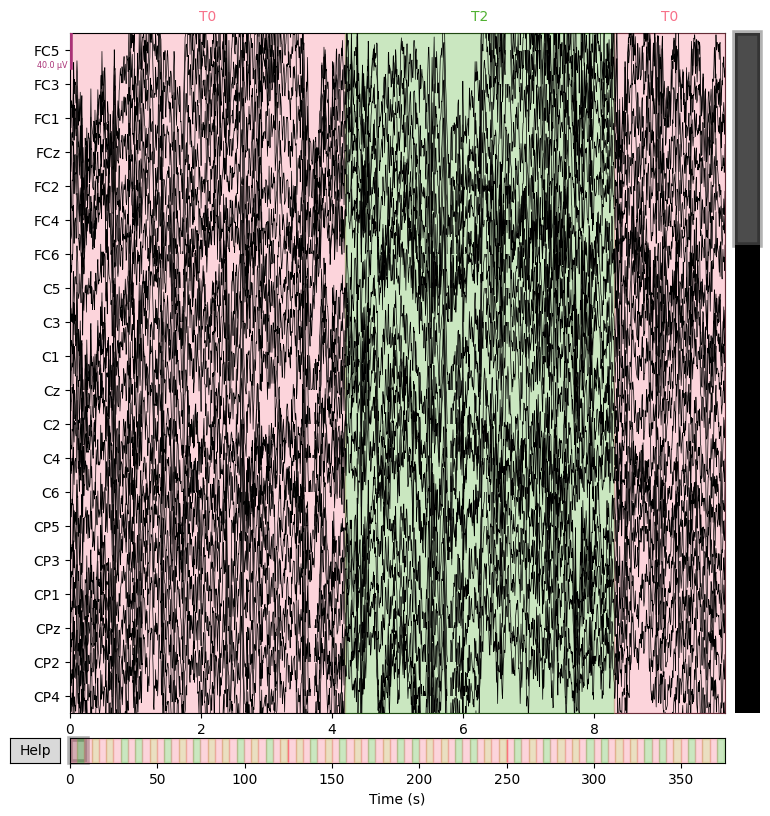


 Event distribution:
   left_hand: 23 events
   right_hand: 22 events
   rest: 45 events


<Figure size 640x480 with 0 Axes>

In [4]:
# Plot raw data (first 10 seconds)
print(" Visualizing raw EEG data (first 10 seconds)...")
fig = raw.plot(duration=10, n_channels=20, scalings={'eeg': 20e-6}, 
               title=f"Raw EEG Data - Subject {SUBJECT}")
plt.tight_layout()

# Plot events
print(f"\n Event distribution:")
event_counts = {name: np.sum(events[:, -1] == id_) for name, id_ in event_id.items()}
for event_name, count in event_counts.items():
    print(f"   {event_name}: {count} events")


In [5]:
# Visualize events on timeline
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

# Plot events
for event_name, event_code in event_id.items():
    event_times = events[events[:, -1] == event_code, 0] / raw.info['sfreq']
    ax.scatter(event_times, [event_code] * len(event_times), 
               label=event_name, alpha=0.7, s=30)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Event Code')
ax.set_title('Event Timeline')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()


##  3. Data Preprocessing

Now we'll preprocess the data including:
- Creating epochs around events
- Band-pass filtering (8-30 Hz for motor imagery)
- Common Average Reference (CAR)
- Artifact rejection
- Optional ICA for artifact removal


In [8]:
# Create epochs
print(" Creating epochs around events...")
TMIN, TMAX = -1.0, 4.0  # 1 second before to 4 seconds after event
BASELINE = (-1.0, 0.0)   # Baseline correction period

epochs = loader.get_epochs(tmin=TMIN, tmax=TMAX, baseline=BASELINE)
print(f"Created {len(epochs)} epochs")
print(f"Epoch shape: {epochs.get_data().shape}")

# Initialize preprocessor
preprocessor = Preprocessor()

# Apply preprocessing
print("\n Applying preprocessing steps...")
L_FREQ, H_FREQ = 8.0, 30.0  # Motor imagery frequency band

epochs_processed = preprocessor.preprocess_epochs(
    epochs,
    l_freq=L_FREQ,
    h_freq=H_FREQ,
    apply_ica=True,  # Skip ICA for faster execution (set to True for better results)
    apply_car=True,   # Apply Common Average Reference
    reject_bad=True   # Reject bad epochs
)

print(f"Preprocessing completed")
print(f"Final epochs: {len(epochs_processed)}")


 Creating epochs around events...
Created 87 epochs
Epoch shape: (87, 64, 801)

 Applying preprocessing steps...
Starting preprocessing pipeline...
Applying band-pass filter (8.0-30.0 Hz)...
Applying Common Average Reference...
Rejecting bad epochs...
Rejected 55 bad epochs
Applying ICA for artifact removal...
Preprocessing completed!
Preprocessing completed
Final epochs: 32


## Preprocessed Data Visualization

Let's visualize the preprocessed data to see the effect of filtering and preprocessing.


In [9]:
# Compare raw vs preprocessed epochs
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot average of raw epochs
epochs_raw = epochs.copy().crop(tmin=0, tmax=3)  # Focus on event period
raw_avg = epochs_raw.average()
raw_avg.plot(axes=axes[0], show=False, titles={'eeg': 'Raw Data (Average)'})
axes[0].set_title('Raw EEG (Average across trials)')

# Plot average of processed epochs
processed_avg = epochs_processed.copy().crop(tmin=0, tmax=3).average()
processed_avg.plot(axes=axes[1], show=False, titles={'eeg': 'Processed Data (Average)'})
axes[1].set_title('Preprocessed EEG (Average across trials)')

plt.tight_layout()


In [10]:
# Plot power spectral density comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Raw data PSD
epochs.plot_psd(fmin=1, fmax=50, ax=axes[0], show=False)
axes[0].set_title('Raw Data - Power Spectral Density')

# Processed data PSD
epochs_processed.plot_psd(fmin=1, fmax=50, ax=axes[1], show=False)
axes[1].set_title('Processed Data - Power Spectral Density')

plt.tight_layout()


##  4. Feature Extraction

We'll extract different types of features for classification:
1. **Common Spatial Patterns (CSP)** - Best for motor imagery
2. **Power Spectral Density (PSD)** - Frequency domain features
3. **Time-domain features** - Statistical features


In [11]:
# Split data into train/test sets
print("Splitting data into train/test sets...")

# Get labels from epochs
labels = epochs_processed.events[:, -1]
print(f"Label distribution: {np.bincount(labels)}")

# Split epochs
from sklearn.model_selection import train_test_split

n_epochs = len(epochs_processed)
indices = np.arange(n_epochs)
train_idx, test_idx = train_test_split(
    indices, test_size=0.2, stratify=labels, random_state=42
)

epochs_train = epochs_processed[train_idx]
epochs_test = epochs_processed[test_idx]
y_train = epochs_train.events[:, -1]
y_test = epochs_test.events[:, -1]

print(f"Training: {len(epochs_train)} epochs")
print(f"Testing: {len(epochs_test)} epochs")
print(f"Train labels: {np.bincount(y_train)}")
print(f"Test labels: {np.bincount(y_test)}")


Splitting data into train/test sets...
Label distribution: [ 0 18  5  9]
Training: 25 epochs
Testing: 7 epochs
Train labels: [ 0 14  4  7]
Test labels: [0 4 1 2]


In [14]:
y_train

array([3, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 3, 3, 2, 2,
       1, 2, 1])

In [13]:
epochs_train.events

array([[24656,     0,     3],
       [30624,     0,     1],
       [47968,     0,     1],
       [17264,     0,     1],
       [ 5984,     0,     3],
       [41328,     0,     1],
       [37936,     0,     2],
       [ 1328,     0,     1],
       [18592,     0,     1],
       [ 6640,     0,     1],
       [38592,     0,     1],
       [37264,     0,     1],
       [47312,     0,     3],
       [50624,     0,     1],
       [36608,     0,     3],
       [13280,     0,     1],
       [29296,     0,     1],
       [31296,     0,     3],
       [40672,     0,     3],
       [59264,     0,     3],
       [33952,     0,     2],
       [42000,     0,     2],
       [10624,     0,     1],
       [44656,     0,     2],
       [58592,     0,     1]])

In [12]:
print(indices)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


### 4.1 Common Spatial Patterns (CSP) Features

CSP finds spatial filters that maximize the variance ratio between different classes.


In [15]:
# Extract CSP features
print("🔧 Extracting CSP features...")

csp_extractor = FeatureExtractor(method='csp', n_components=6)
X_train_csp = csp_extractor.fit_transform(epochs_train, y_train)
X_test_csp = csp_extractor.transform(epochs_test, y_test)

print(f" CSP features extracted!")
print(f" Training features shape: {X_train_csp.shape}")
print(f" Testing features shape: {X_test_csp.shape}")

# Visualize CSP patterns
csp = csp_extractor.csp
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for i, ax in enumerate(axes):
    mne.viz.plot_topomap(csp.patterns_[i], epochs_processed.info, axes=ax, show=False)
    ax.set_title(f'CSP Pattern {i+1}')

plt.suptitle('CSP Spatial Patterns')
plt.tight_layout()


🔧 Extracting CSP features...
 CSP features extracted!
 Training features shape: (25, 6)
 Testing features shape: (7, 6)


### 4.2 Power Spectral Density (PSD) Features

PSD features capture frequency-domain information in different EEG bands.


In [17]:
# Extract PSD features
print(" Extracting PSD features...")

psd_extractor = FeatureExtractor(method='psd')
X_train_psd = psd_extractor.fit_transform(epochs_train, y_train)
X_test_psd = psd_extractor.transform(epochs_test)

print(f" PSD features extracted!")
print(f"Training features shape: {X_train_psd.shape}")
print(f" Testing features shape: {X_test_psd.shape}")

# Visualize average PSD features by class
fig, ax = plt.subplots(figsize=(12, 6))

# Create DataFrame for easier plotting
feature_names = psd_extractor.get_feature_names()
psd_df = pd.DataFrame(X_train_psd, columns=feature_names)
psd_df['class'] = y_train

# Plot average PSD by frequency band for first few channels
bands = ['alpha', 'beta', 'gamma', 'theta']
channels = ['C3', 'C4', 'Cz']  # Motor cortex channels

plot_data = []
for band in bands:
    for channel in channels:
        if any(f'{channel}_{band}' in col for col in feature_names):
            col_name = next(col for col in feature_names if f'{channel}_{band}' in col)
            for class_id in np.unique(y_train):
                class_name = [k for k, v in event_id.items() if v == class_id][0]
                mean_power = psd_df[psd_df['class'] == class_id][col_name].mean()
                plot_data.append({'band': band, 'channel': channel, 
                                'class': class_name, 'power': mean_power})

plot_df = pd.DataFrame(plot_data)
sns.barplot(data=plot_df, x='band', y='power', hue='class')
plt.title('Average PSD Features by Frequency Band and Class')
plt.ylabel('Power')
plt.xticks(rotation=45)
plt.tight_layout()


 Extracting PSD features...
 PSD features extracted!
Training features shape: (25, 256)
 Testing features shape: (7, 256)


### 4.3 Time-Domain Features

Statistical features extracted from the time series data.


In [18]:
# Extract time-domain features
print(" Extracting time-domain features...")

time_extractor = FeatureExtractor(method='time_domain')
X_train_time = time_extractor.fit_transform(epochs_train, y_train)
X_test_time = time_extractor.transform(epochs_test)

print(f" Time-domain features extracted!")
print(f" Training features shape: {X_train_time.shape}")
print(f" Testing features shape: {X_test_time.shape}")

# Visualize time-domain features
time_feature_names = time_extractor.get_feature_names()
print(f" Time-domain features (first 10): {time_feature_names[:10]}")


 Extracting time-domain features...
 Time-domain features extracted!
 Training features shape: (25, 448)
 Testing features shape: (7, 448)
 Time-domain features (first 10): ['FC5_mean', 'FC5_std', 'FC5_var', 'FC5_skew', 'FC5_kurt', 'FC5_rms', 'FC5_peak_to_peak', 'FC3_mean', 'FC3_std', 'FC3_var']


##  5. Classification

Now we'll train and evaluate different classification algorithms on our features.

### 5.1 CSP + SVM Classification


 Training SVM classifier on CSP features...
SVM Test Accuracy: 0.571
 SVM CV Accuracy: 0.520 ± 0.160


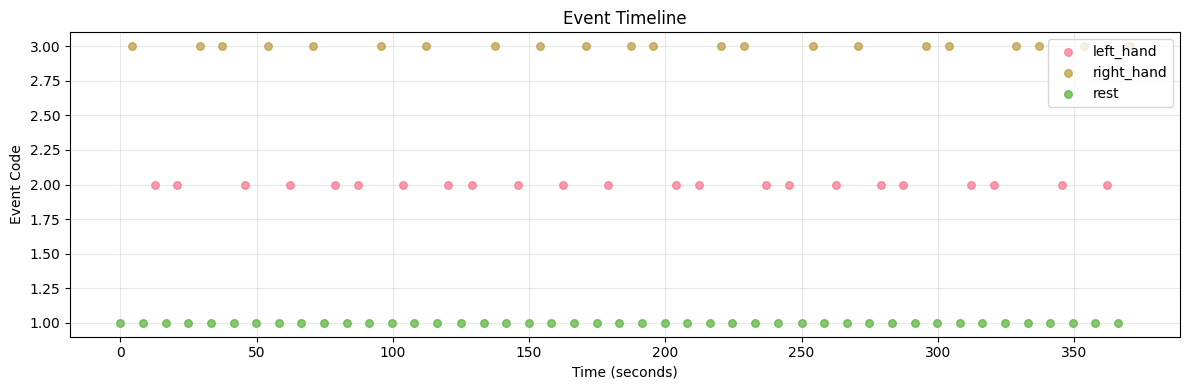

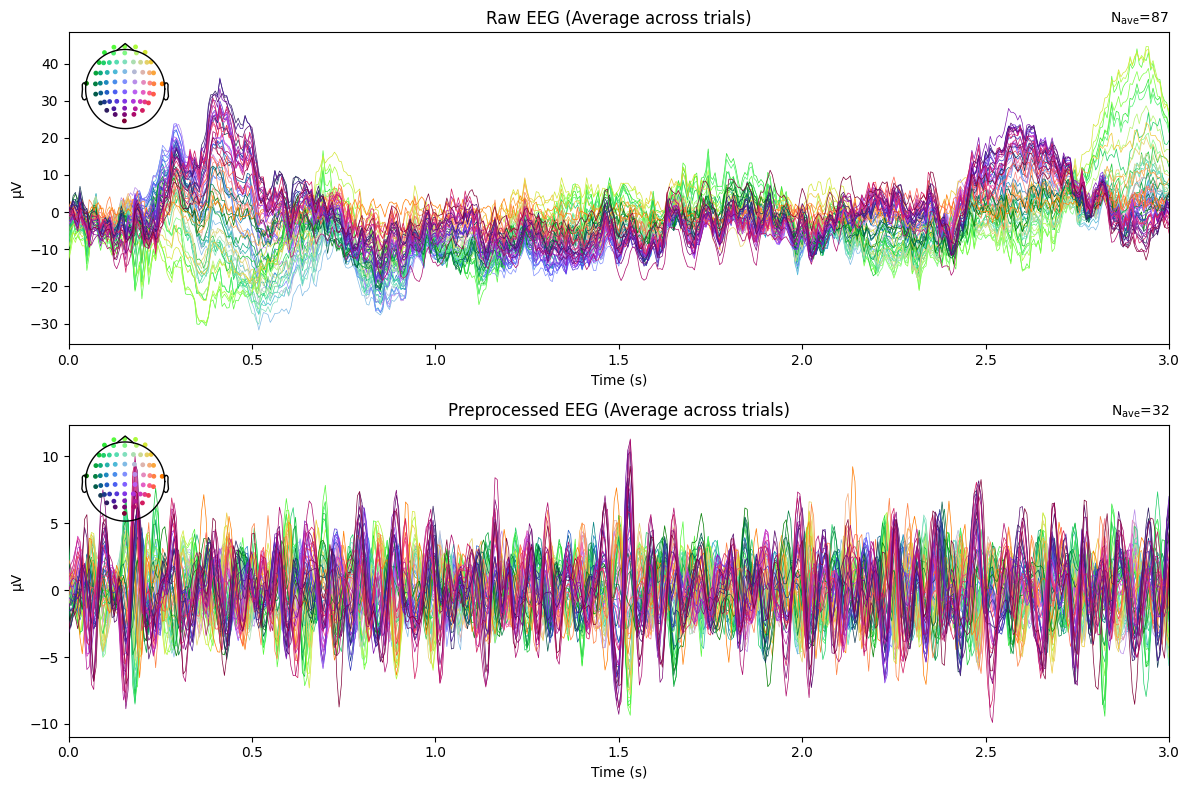

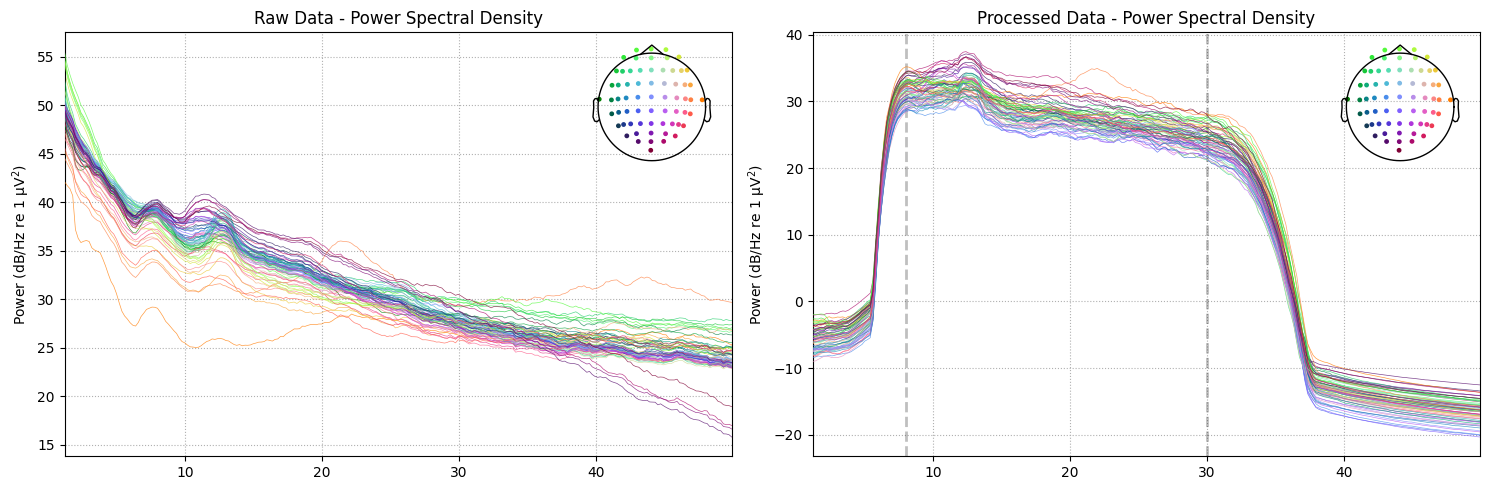

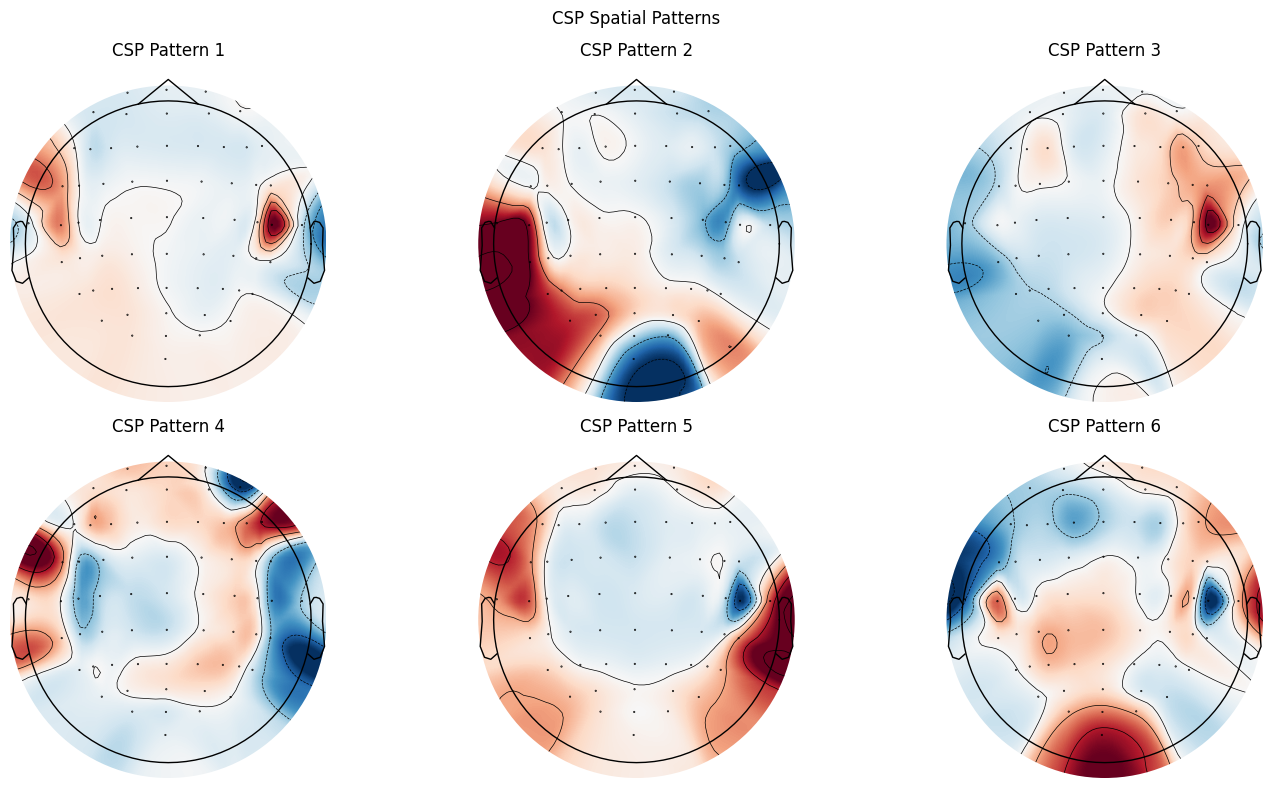

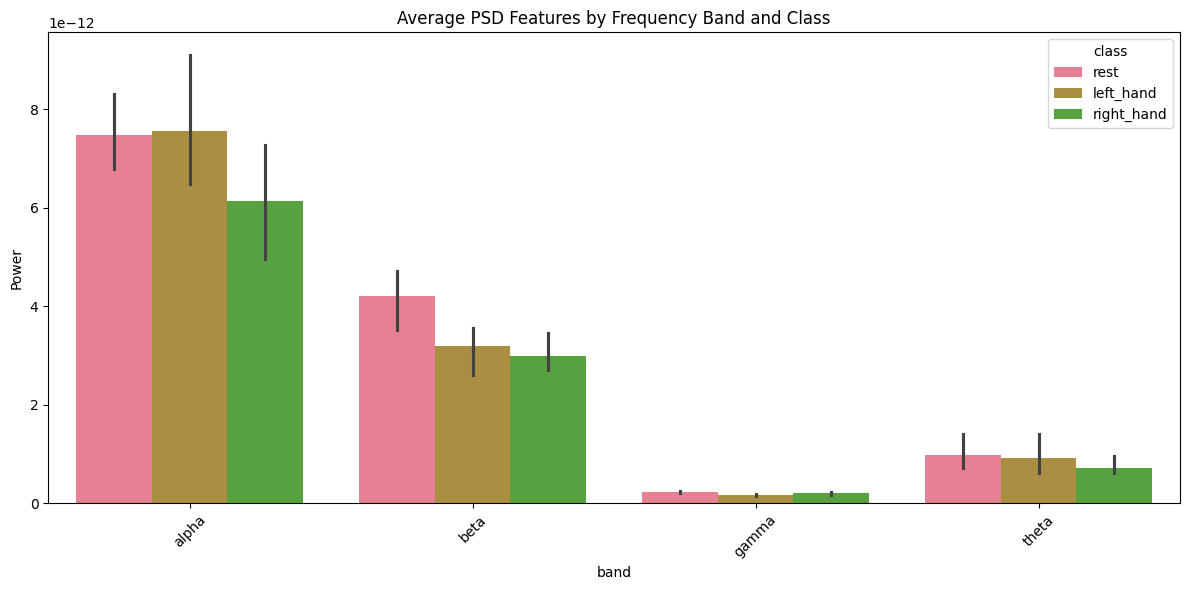

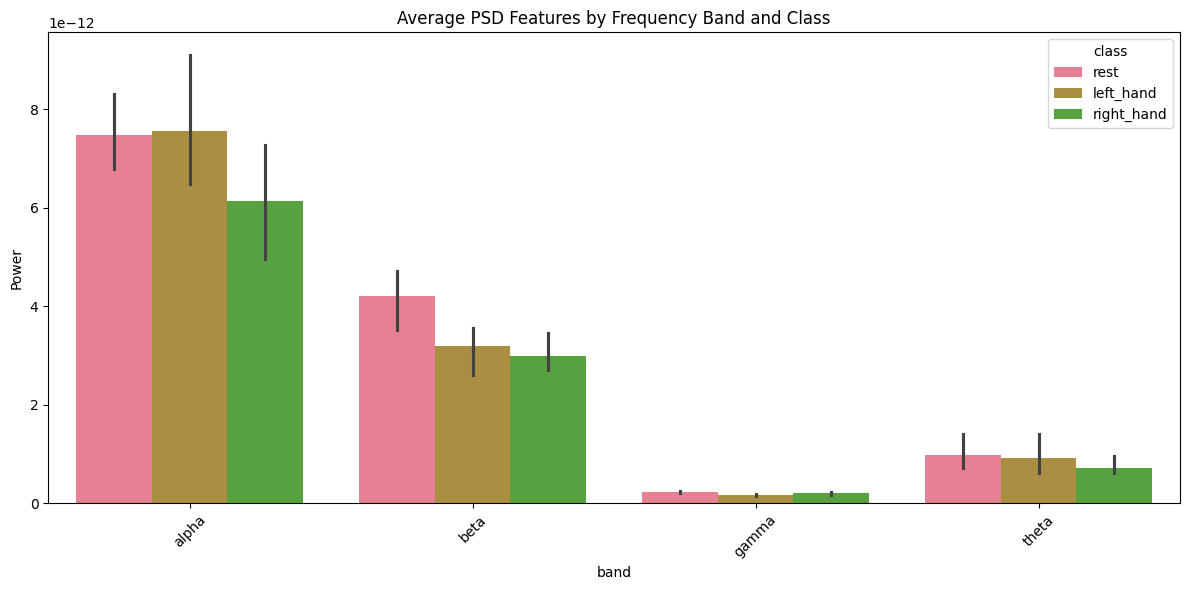

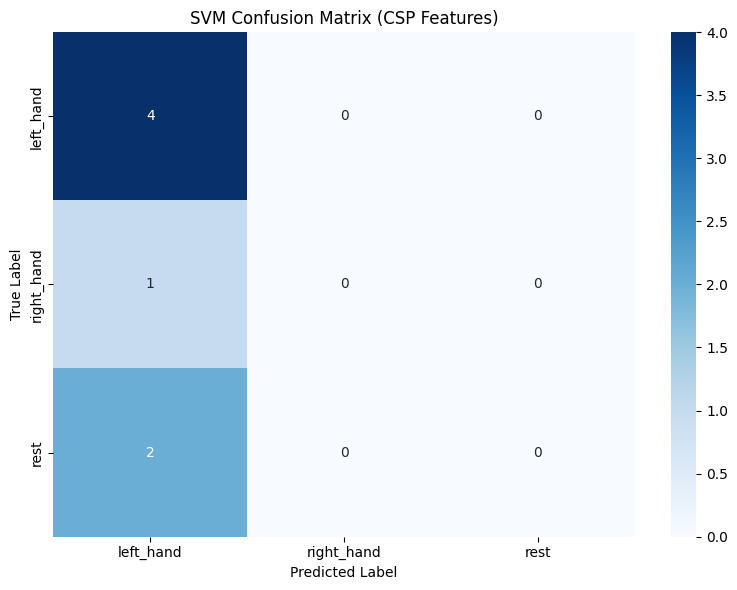

In [19]:
# Train SVM classifier on CSP features
print(" Training SVM classifier on CSP features...")

svm_classifier = BCIClassifier(algorithm='svm', random_state=42)
svm_classifier.fit(X_train_csp, y_train, normalize=True)

# Evaluate on test set
results_svm = svm_classifier.evaluate(X_test_csp, y_test, normalize=True)
print(f"SVM Test Accuracy: {results_svm['accuracy']:.3f}")

# Cross-validation on training set
cv_results_svm = svm_classifier.cross_validate(X_train_csp, y_train, cv=5)
print(f" SVM CV Accuracy: {cv_results_svm['mean_accuracy']:.3f} ± {cv_results_svm['std_accuracy']:.3f}")

# Plot confusion matrix
class_names = list(event_id.keys())
svm_classifier.plot_confusion_matrix(
    results_svm['confusion_matrix'], 
    class_names=class_names,
    title='SVM Confusion Matrix (CSP Features)'
)


### 5.2 Algorithm Comparison

Let's compare multiple algorithms on CSP features:


In [20]:
# Compare multiple algorithms
print(" Comparing multiple classification algorithms...")

algorithms = ['svm', 'lda', 'rf', 'lr']
comparison_results = {}

for alg in algorithms:
    print(f"Training {alg.upper()}...")
    classifier = BCIClassifier(algorithm=alg, random_state=42)
    
    # Cross-validation
    cv_results = classifier.cross_validate(X_train_csp, y_train, cv=5)
    
    # Train and test
    classifier.fit(X_train_csp, y_train)
    test_results = classifier.evaluate(X_test_csp, y_test)
    
    comparison_results[alg] = {
        'cv_accuracy': cv_results['mean_accuracy'],
        'cv_std': cv_results['std_accuracy'],
        'test_accuracy': test_results['accuracy']
    }
    
    print(f"   {alg.upper()} - CV: {cv_results['mean_accuracy']:.3f}±{cv_results['std_accuracy']:.3f}, Test: {test_results['accuracy']:.3f}")


 Comparing multiple classification algorithms...
Training SVM...
   SVM - CV: 0.520±0.160, Test: 0.571
Training LDA...
   LDA - CV: 0.720±0.204, Test: 0.571
Training RF...
   RF - CV: 0.560±0.150, Test: 0.714
Training LR...
   LR - CV: 0.600±0.219, Test: 0.714


### 5.3 Results Visualization


In [21]:
# Plot algorithm comparison
algorithms = list(comparison_results.keys())
cv_means = [comparison_results[alg]['cv_accuracy'] for alg in algorithms]
cv_stds = [comparison_results[alg]['cv_std'] for alg in algorithms]
test_accs = [comparison_results[alg]['test_accuracy'] for alg in algorithms]

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Cross-validation results
axes[0].bar(algorithms, cv_means, yerr=cv_stds, capsize=5, alpha=0.7)
axes[0].set_title('Cross-Validation Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0, 1)
for i, (mean, std) in enumerate(zip(cv_means, cv_stds)):
    axes[0].text(i, mean + std + 0.02, f'{mean:.3f}±{std:.3f}', 
                ha='center', va='bottom')

# Test accuracy
bars = axes[1].bar(algorithms, test_accs, alpha=0.7)
axes[1].set_title('Test Accuracy')
axes[1].set_ylabel('Accuracy')
axes[1].set_ylim(0, 1)
for i, acc in enumerate(test_accs):
    axes[1].text(i, acc + 0.02, f'{acc:.3f}', ha='center', va='bottom')

# Highlight best algorithm
best_alg_idx = np.argmax(cv_means)
bars[best_alg_idx].set_color('gold')

plt.tight_layout()

# Print best algorithm
best_alg = algorithms[best_alg_idx]
print(f" Best Algorithm: {best_alg.upper()} (CV: {cv_means[best_alg_idx]:.3f}±{cv_stds[best_alg_idx]:.3f})")


 Best Algorithm: LDA (CV: 0.720±0.204)


### 5.4 Feature Method Comparison

Let's compare different feature extraction methods:


In [25]:
# Compare feature methods using the best classifier
print("Comparing feature extraction methods...")

best_classifier_alg = algorithms[np.argmax(cv_means)]
feature_results = {}

# CSP features (already computed)
feature_results['CSP'] = {
    'X_train': X_train_csp,
    'X_test': X_test_csp,
    'accuracy': comparison_results[best_classifier_alg]['test_accuracy']
}

# PSD features
classifier_psd = BCIClassifier(algorithm=best_classifier_alg, random_state=42)
classifier_psd.fit(X_train_psd, y_train)
results_psd = classifier_psd.evaluate(X_test_psd, y_test)
feature_results['PSD'] = {
    'X_train': X_train_psd,
    'X_test': X_test_psd,
    'accuracy': results_psd['accuracy']
}

# Time-domain features
classifier_time = BCIClassifier(algorithm=best_classifier_alg, random_state=42)
classifier_time.fit(X_train_time, y_train)
results_time = classifier_time.evaluate(X_test_time, y_test)
feature_results['Time-domain'] = {
    'X_train': X_train_time,
    'X_test': X_test_time,
    'accuracy': results_time['accuracy']
}

# Combined features
combined_extractor = FeatureExtractor(method='combined', n_components=6)
X_train_combined = combined_extractor.fit_transform(epochs_train, y_train)
X_test_combined = combined_extractor.transform(epochs_test, y_test)

classifier_combined = BCIClassifier(algorithm=best_classifier_alg, random_state=42)
classifier_combined.fit(X_train_combined, y_train)
results_combined = classifier_combined.evaluate(X_test_combined, y_test)
feature_results['Combined'] = {
    'X_train': X_train_combined,
    'X_test': X_test_combined,
    'accuracy': results_combined['accuracy']
}

# Plot feature method comparison
feature_methods = list(feature_results.keys())
feature_accuracies = [feature_results[method]['accuracy'] for method in feature_methods]

plt.figure(figsize=(10, 6))
bars = plt.bar(feature_methods, feature_accuracies, alpha=0.7)
plt.title(f'Feature Method Comparison ({best_classifier_alg.upper()} Classifier)')
plt.ylabel('Test Accuracy')
plt.ylim(0, 1)

# Add accuracy labels
for i, acc in enumerate(feature_accuracies):
    plt.text(i, acc + 0.02, f'{acc:.3f}', ha='center', va='bottom')

# Highlight best method
best_feature_idx = np.argmax(feature_accuracies)
bars[best_feature_idx].set_color('gold')

plt.tight_layout()

print(f"🏆 Best Feature Method: {feature_methods[best_feature_idx]} (Accuracy: {feature_accuracies[best_feature_idx]:.3f})")


Comparing feature extraction methods...
🏆 Best Feature Method: CSP (Accuracy: 0.571)


##  6. Complete Pipeline



In [26]:
# Initialize complete pipeline
print("Running complete BCI classification pipeline...")

pipeline = BCIPipeline(
    dataset='eegbci',
    feature_method='csp',
    classifier_algorithm='svm',
    random_state=42
)

# Run complete pipeline
pipeline_results = pipeline.run_complete_pipeline(
    subject=SUBJECT,
    runs=RUNS,
    tmin=TMIN,
    tmax=TMAX,
    l_freq=L_FREQ,
    h_freq=H_FREQ,
    test_size=0.2,
    apply_ica=True,  # Set to True for better results (but slower)
    normalize_features=True
)

print(f" Pipeline Results:")
print(f"   Test Accuracy: {pipeline_results['test_accuracy']:.3f}")
print(f"   CV Accuracy: {pipeline_results['cv_mean_accuracy']:.3f} ± {pipeline_results['cv_std_accuracy']:.3f}")

# Get pipeline summary
summary = pipeline.get_pipeline_summary()
print(f"\n Pipeline Configuration:")
config = summary['configuration']
for key, value in config.items():
    print(f"   {key}: {value}")


Running complete BCI classification pipeline...
RUNNING COMPLETE BCI CLASSIFICATION PIPELINE
Loading eegbci dataset...
Data loaded successfully!
Dataset info: {'n_channels': 64, 'channel_names': ['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz'], 'sampling_rate': 160.0, 'duration': np.float64(374.99375), 'n_events': 90, 'event_types': ['left_hand', 'right_hand', 'rest']}
Creating epochs...
Created 87 epochs
Epoch shape: (87, 64, 801)
Preprocessing data...
Starting preprocessing pipeline...
Applying band-pass filter (8.0-30.0 Hz)...
Applying Common Average Reference...
Rejecting bad epochs...
Rejected 55 bad epochs
Applying ICA

## 7. Final Results Summary


In [27]:
# Create comprehensive results summary
print(" FINAL RESULTS SUMMARY")
print("=" * 50)

# Individual component results
print(f"\nBest Individual Results:")
print(f"   Algorithm: {best_alg.upper()} (CV: {cv_means[best_alg_idx]:.3f}±{cv_stds[best_alg_idx]:.3f})")
print(f"   Feature Method: {feature_methods[best_feature_idx]} (Test: {feature_accuracies[best_feature_idx]:.3f})")

# Complete pipeline results
print(f"\nComplete Pipeline Results:")
print(f"   Test Accuracy: {pipeline_results['test_accuracy']:.3f}")
print(f"   CV Accuracy: {pipeline_results['cv_mean_accuracy']:.3f} ± {pipeline_results['cv_std_accuracy']:.3f}")

# Dataset information
print(f"\nDataset Information:")
print(f"   Subject: {SUBJECT}")
print(f"   Runs: {RUNS}")
print(f"   Total epochs: {len(epochs_processed)}")
print(f"   Features: {X_train_csp.shape[1]} (CSP)")
print(f"   Classes: {len(event_id)} ({', '.join(event_id.keys())})")

# Create final visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Algorithm comparison
axes[0, 0].bar(algorithms, cv_means, alpha=0.7)
axes[0, 0].set_title('Algorithm Comparison (CV Accuracy)')
axes[0, 0].set_ylabel('Accuracy')
for i, mean in enumerate(cv_means):
    axes[0, 0].text(i, mean + 0.01, f'{mean:.3f}', ha='center')

# Feature method comparison
axes[0, 1].bar(feature_methods, feature_accuracies, alpha=0.7)
axes[0, 1].set_title('Feature Method Comparison')
axes[0, 1].set_ylabel('Test Accuracy')
for i, acc in enumerate(feature_accuracies):
    axes[0, 1].text(i, acc + 0.01, f'{acc:.3f}', ha='center')

# Confusion matrix for best model
best_features = feature_results[feature_methods[best_feature_idx]]
best_classifier = BCIClassifier(algorithm=best_alg, random_state=42)
best_classifier.fit(best_features['X_train'], y_train)
best_results = best_classifier.evaluate(best_features['X_test'], y_test)

cm = best_results['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=class_names, yticklabels=class_names)
axes[1, 0].set_title(f'Best Model Confusion Matrix\n({best_alg.upper()} + {feature_methods[best_feature_idx]})')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# Performance timeline
performance_data = {
    'CSP+SVM': results_svm['accuracy'],
    'Best Algorithm': cv_means[best_alg_idx],
    'Best Features': feature_accuracies[best_feature_idx],
    'Complete Pipeline': pipeline_results['test_accuracy']
}

methods = list(performance_data.keys())
accuracies = list(performance_data.values())
colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold']

axes[1, 1].bar(methods, accuracies, color=colors, alpha=0.7)
axes[1, 1].set_title('Performance Progression')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].tick_params(axis='x', rotation=45)
for i, acc in enumerate(accuracies):
    axes[1, 1].text(i, acc + 0.01, f'{acc:.3f}', ha='center')

plt.tight_layout()


 FINAL RESULTS SUMMARY

Best Individual Results:
   Algorithm: LDA (CV: 0.720±0.204)
   Feature Method: CSP (Test: 0.571)

Complete Pipeline Results:
   Test Accuracy: 0.571
   CV Accuracy: 0.600 ± 0.126

Dataset Information:
   Subject: 1
   Runs: [4, 8, 12]
   Total epochs: 32
   Features: 6 (CSP)
   Classes: 3 (left_hand, right_hand, rest)


In [28]:
# Save the best pipeline for future use
pipeline_path = "best_bci_pipeline.pkl"
pipeline.save_pipeline(pipeline_path)
print(f" Best pipeline saved to: {pipeline_path}")

Pipeline saved to best_bci_pipeline.pkl
 Best pipeline saved to: best_bci_pipeline.pkl
